# Machine Learning Modeling

**Description:** 
This notebook contains the code for building and evaluating machine learning models to predict diabetes and hypertension prevalence based on PM2.5 levels and other features. The models are trained with control for confounding variables and include interaction terms to assess the impact of outside factors like urbanization and socioeconomic status.

## 1. Setup and Data Preparation

In this section, we will import necessary libraries, load the dataset, and perform data processing and normalization.

In [8]:
import os, csv
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from utils import build_dataset

In [9]:
# Load the dataset
data = build_dataset()

# Select features and targets to be used in modeling
features = ["avg_pm25","smoking","obesity","no_lt_physical_activity","binge_drinking","lack_of_health_insurance","routine_checkup","food_insecurity","housing_insecurity","urbanization_level"]
targets = ["diabetes","hypertension"]

# Split the dataset into features and target variables
X = data[features]
y = data[targets]

In [10]:
# Split the dataset into features and target variables for evaluating model performance
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1624, 10), (407, 10), (1624, 2), (407, 2))

In [11]:
X_train.head()

,avg_pm25,smoking,obesity,no_lt_physical_activity,binge_drinking,lack_of_health_insurance,routine_checkup,food_insecurity,housing_insecurity,urbanization_level
1683,6.549546,16.704815,37.383491,27.787189,18.058957,17.555141,73.811043,14.930126,12.819815,6.0
471,8.458216,13.100000,35.700000,23.300000,21.700000,6.100000,79.100000,7.200000,7.100000,6.0
744,6.526506,19.896181,39.260925,25.995817,19.140221,7.028860,76.929655,15.857115,13.280515,5.0
1111,6.826042,14.800000,38.000000,26.200000,18.000000,8.200000,76.000000,10.400000,8.800000,6.0
1481,8.826063,20.821889,42.944760,31.337431,14.229319,14.886096,80.701485,23.386609,18.745315,2.0


In [12]:
y_train.head()

,diabetes,hypertension
1683,13.702892,37.099061
471,10.600000,31.600000
744,12.092917,36.131869
1111,12.100000,39.100000
1481,16.337077,41.789732


Normalization is done by subtracting the mean and dividing by the standard deviation of feature values where the formula is defined as:
$$
{z} = \frac{x_{i,j} - \tilde{x}_{j}}{sd(x_{j})}
$$


In [13]:
# Normalize the numeric features (features except "urbanization_level" which is categorical) on X
scaler = StandardScaler()

numeric_features = features.copy()
numeric_features.remove("urbanization_level")

X_scaled = X.copy()
X_scaled[numeric_features] = scaler.fit_transform(X[numeric_features])

In [14]:
# Normalize the numeric features on X_train and X_test
scaler = StandardScaler()

X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

# Fit the scaler on the training data and normalize both training and test data
X_train_scaled[numeric_features] = scaler.fit_transform(X_train[numeric_features])
X_test_scaled[numeric_features] = scaler.transform(X_test[numeric_features])

In [15]:
X_train_scaled.head()

,avg_pm25,smoking,obesity,no_lt_physical_activity,binge_drinking,lack_of_health_insurance,routine_checkup,food_insecurity,housing_insecurity,urbanization_level
1683,-1.229986,-0.274834,-0.203155,-0.083074,0.664311,0.958623,-0.725213,-0.192270,-0.104958,6.0
471,0.198062,-1.229711,-0.570384,-0.918064,2.054788,-0.974968,0.778932,-1.438531,-1.441306,6.0
744,-1.247225,0.570526,0.206379,-0.416418,1.077235,-0.818179,0.161700,-0.042820,0.002678,5.0
1111,-1.023115,-0.779399,-0.068673,-0.378423,0.641796,-0.620494,-0.102688,-0.922623,-1.044127,6.0
1481,0.473281,0.815736,1.009954,0.577566,-0.798187,0.508097,1.234384,1.171095,1.279446,2.0


## 2. Linear Regression Model for PM2.5 and Diabetes/Hypertension Prevalence ($H_1$)

To test the main hypothesis that higher PM2.5 levels are associated with increased prevalence of diabetes and hypertension, we will build regression models controlling for confounding variables.

### 2.1 - OLS Regression Model with Interaction Terms

We will build two separate OLS regression models: one for diabetes prevalence and another for hypertension prevalence. Both models will include interaction terms to assess how the relationship between PM2.5 and health outcomes varies by different confounding factors.

In [16]:
# Statsmodels OLS Regression with Interaction Terms
import statsmodels.api as sm
import statsmodels.formula.api as smf
from utils import ols_summary

In [17]:
formula_diabetes = "diabetes ~ avg_pm25" \
    " + smoking" \
    " + obesity" \
    " + no_lt_physical_activity" \
    " + binge_drinking" \
    " + lack_of_health_insurance" \
    " + routine_checkup" \
    " + food_insecurity" \
    " + housing_insecurity" \
    " + C(urbanization_level)"

formula_hypertension = "hypertension ~ avg_pm25" \
    " + smoking" \
    " + obesity" \
    " + no_lt_physical_activity" \
    " + binge_drinking" \
    " + lack_of_health_insurance" \
    " + routine_checkup" \
    " + food_insecurity" \
    " + housing_insecurity" \
    " + C(urbanization_level)"

In [18]:
model_diabetes = smf.ols(formula=formula_diabetes, data=pd.concat([X_scaled, y], axis=1)).fit()
model_hypertension = smf.ols(formula=formula_hypertension, data=pd.concat([X_scaled, y], axis=1)).fit()
model_diabetes.mse_resid, model_hypertension.mse_resid

(np.float64(0.9356413793708996), np.float64(5.14069068251815))

In [19]:
model_diabetes.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               diabetes   R-squared:                       0.877
Model:                            OLS   Adj. R-squared:                  0.876
Method:                 Least Squares   F-statistic:                     1029.
Date:                Fri, 09 Jan 2026   Prob (F-statistic):               0.00
Time:                        16:52:04   Log-Likelihood:                -2806.8
No. Observations:                2031   AIC:                             5644.
Df Residuals:                    2016   BIC:                             5728.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                       13.7995      0.173     79.718      0.000      13.460      14.139
C(urbanization_level)[T.2.0]    -0.2628      0.183     -1.434      0.152      -0.622       0.097
C(urbanization_level)[T.3.0]    -0.2889      0.181     -1.593      0.111      -0.645       0.067
C(urbanization_level)[T.4.0]    -0.2965      0.183     -1.620      0.105      -0.655       0.062
C(urbanization_level)[T.5.0]    -0.3151      0.179     -1.760      0.079      -0.666       0.036
C(urbanization_level)[T.6.0]    -0.0615      0.179     -0.344      0.731      -0.412       0.289
avg_pm25                        -0.1142      0.024     -4.818      0.000      -0.161      -0.068
smoking                          0.2128      0.047      4.550      0.000       0.121       0.305
obesity                          0.2213      0.037      5.998      0.000       0.149       0.294
no_lt_physical_activity          0.9644      0.070     13.787      0.000       0.827       1.102
binge_drinking                  -0.5202      0.031    -16.705      0.000      -0.581      -0.459
lack_of_health_insurance         0.4642      0.044     10.561      0.000       0.378       0.550
routine_checkup                  0.5790      0.029     19.711      0.000       0.521       0.637
food_insecurity                  0.9582      0.158      6.046      0.000       0.647       1.269
housing_insecurity              -0.4591      0.139     -3.314      0.001      -0.731      -0.187
==============================================================================
Omnibus:                       78.572   Durbin-Watson:                   1.164
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              219.998
Skew:                          -0.101   Prob(JB):                     1.69e-48
Kurtosis:                       4.600   Cond. No.                         42.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [20]:
model_hypertension.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           hypertension   R-squared:                       0.836
Model:                            OLS   Adj. R-squared:                  0.835
Method:                 Least Squares   F-statistic:                     733.8
Date:                Fri, 09 Jan 2026   Prob (F-statistic):               0.00
Time:                        16:52:04   Log-Likelihood:                -4536.9
No. Observations:                2031   AIC:                             9104.
Df Residuals:                    2016   BIC:                             9188.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                       36.3399      0.406     89.562      0.000      35.544      37.136
C(urbanization_level)[T.2.0]     1.0386      0.430      2.418      0.016       0.196       1.881
C(urbanization_level)[T.3.0]     1.1583      0.425      2.725      0.006       0.325       1.992
C(urbanization_level)[T.4.0]     1.1214      0.429      2.614      0.009       0.280       1.963
C(urbanization_level)[T.5.0]     1.2299      0.420      2.930      0.003       0.407       2.053
C(urbanization_level)[T.6.0]     1.8785      0.419      4.489      0.000       1.058       2.699
avg_pm25                        -0.2483      0.056     -4.469      0.000      -0.357      -0.139
smoking                          1.3155      0.110     12.000      0.000       1.100       1.530
obesity                          0.7075      0.086      8.181      0.000       0.538       0.877
no_lt_physical_activity          0.8370      0.164      5.105      0.000       0.515       1.159
binge_drinking                  -2.1317      0.073    -29.207      0.000      -2.275      -1.989
lack_of_health_insurance         0.2355      0.103      2.285      0.022       0.033       0.437
routine_checkup                  1.8394      0.069     26.716      0.000       1.704       1.974
food_insecurity                 -1.2564      0.371     -3.382      0.001      -1.985      -0.528
housing_insecurity               1.1616      0.325      3.577      0.000       0.525       1.798
==============================================================================
Omnibus:                       23.518   Durbin-Watson:                   1.273
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               27.546
Skew:                          -0.194   Prob(JB):                     1.04e-06
Kurtosis:                       3.418   Cond. No.                         42.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Interpretation of Coefficients:**
- The negative coefficient for `avg_pm25` indicates that there is an inverse relationship between PM2.5 levels and diabetes, hypertension prevalence when controlling for other factors. This contradiction with our initial hypothesis suggests that there may be collinearity or other confounding effects at play.

To further investigate, we will examine the covariance of features to identify potential multicollinearity issues.

### 2.2 - Multicollinearity Check

In this section, we will use Variance Inflation Factor (VIF) to check for multicollinearity among the features used in the regression models. High VIF values indicate that a feature is highly collinear with other features, which can distort the regression coefficients and their interpretations.

In [21]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

X_vif = X
# add a constant for VIF calculation
X_vif = sm.add_constant(X_vif)

vif_data = pd.DataFrame()
vif_data["feature"] = X_vif.columns
vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]

vif_data

,feature,VIF
0,const,1029.527001
1,avg_pm25,1.210696
2,smoking,4.731740
3,obesity,2.897279
4,no_lt_physical_activity,10.561415
5,binge_drinking,2.095132
6,lack_of_health_insurance,4.165971
7,routine_checkup,1.862111
8,food_insecurity,54.431913
9,housing_insecurity,41.642344


The results of the VIF analysis show that no_lt_physical_activity, food_insecurity and housing_insecurity have high VIF values, indicating potential multicollinearity issues. In order to address this, we will combine these features into a single composite variable called "lifestyle_insecurity" by taking their average.

In [22]:
X_scaled["lifestyle_insecurity"] = X_scaled[["no_lt_physical_activity", "food_insecurity", "housing_insecurity"]].mean(axis=1)
# Drop the original features
X_scaled = X_scaled.drop(columns=["no_lt_physical_activity", "food_insecurity", "housing_insecurity"])

# Scale the new feature
scaler = StandardScaler()
X_scaled["lifestyle_insecurity"] = scaler.fit_transform(X_scaled[["lifestyle_insecurity"]])

X_scaled[["lifestyle_insecurity"]].head()

,lifestyle_insecurity
0,-0.240699
1,-0.548915
2,2.016696
3,0.904355
4,0.015868


In [23]:
# Redo VIF calculation after combining features
X_vif = X_scaled
# Add a constant for VIF calculation
X_vif = sm.add_constant(X_vif)

vif_data = pd.DataFrame()
vif_data["feature"] = X_vif.columns
vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]

vif_data

,feature,VIF
0,const,12.370022
1,avg_pm25,1.209461
2,smoking,2.946046
3,obesity,2.480474
4,binge_drinking,1.836951
5,lack_of_health_insurance,3.718259
6,routine_checkup,1.713318
7,urbanization_level,1.139615
8,lifestyle_insecurity,6.779524


The constructed composite lifestyle insecurity index addressed multicollinearity among socioeconomic variables. Variance inflation factors in the final models were all below 7, indicating acceptable levels of collinearity.

A revised OLS regression model will be built using the new composite variable to reassess the relationship between PM2.5 and health outcomes.

In [24]:
formula_diabetes_revised = "diabetes ~ avg_pm25" \
    " + smoking" \
    " + obesity" \
    " + binge_drinking" \
    " + lack_of_health_insurance" \
    " + routine_checkup" \
    " + lifestyle_insecurity" \
    " + C(urbanization_level)"

formula_hypertension_revised = "hypertension ~ avg_pm25" \
    " + smoking" \
    " + obesity" \
    " + binge_drinking" \
    " + lack_of_health_insurance" \
    " + routine_checkup" \
    " + lifestyle_insecurity" \
    " + C(urbanization_level)"

model_diabetes_revised = smf.ols(formula=formula_diabetes_revised, data=pd.concat([X_scaled, y], axis=1)).fit()
model_hypertension_revised = smf.ols(formula=formula_hypertension_revised, data=pd.concat([X_scaled, y], axis=1)).fit()
model_diabetes_revised.mse_resid, model_hypertension_revised.mse_resid    

(np.float64(1.0044410698162636), np.float64(5.204203868210578))

In [25]:
model_diabetes_revised.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               diabetes   R-squared:                       0.868
Model:                            OLS   Adj. R-squared:                  0.867
Method:                 Least Squares   F-statistic:                     1106.
Date:                Fri, 09 Jan 2026   Prob (F-statistic):               0.00
Time:                        16:52:05   Log-Likelihood:                -2879.8
No. Observations:                2031   AIC:                             5786.
Df Residuals:                    2018   BIC:                             5859.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                       13.7848      0.179     76.870      0.000      13.433      14.136
C(urbanization_level)[T.2.0]    -0.3319      0.190     -1.749      0.080      -0.704       0.040
C(urbanization_level)[T.3.0]    -0.3244      0.188     -1.727      0.084      -0.693       0.044
C(urbanization_level)[T.4.0]    -0.2933      0.190     -1.547      0.122      -0.665       0.079
C(urbanization_level)[T.5.0]    -0.3041      0.185     -1.639      0.101      -0.668       0.060
C(urbanization_level)[T.6.0]     0.0012      0.185      0.007      0.995      -0.361       0.364
avg_pm25                        -0.1158      0.025     -4.719      0.000      -0.164      -0.068
smoking                          0.5650      0.038     14.793      0.000       0.490       0.640
obesity                          0.3226      0.035      9.116      0.000       0.253       0.392
binge_drinking                  -0.6289      0.030    -20.831      0.000      -0.688      -0.570
lack_of_health_insurance         0.6281      0.043     14.608      0.000       0.544       0.712
routine_checkup                  0.6580      0.029     22.545      0.000       0.601       0.715
lifestyle_insecurity             0.8719      0.058     14.942      0.000       0.757       0.986
==============================================================================
Omnibus:                       43.207   Durbin-Watson:                   1.216
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               91.005
Skew:                          -0.028   Prob(JB):                     1.73e-20
Kurtosis:                       4.035   Cond. No.                         35.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [26]:
model_hypertension_revised.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           hypertension   R-squared:                       0.834
Model:                            OLS   Adj. R-squared:                  0.833
Method:                 Least Squares   F-statistic:                     843.4
Date:                Fri, 09 Jan 2026   Prob (F-statistic):               0.00
Time:                        16:52:05   Log-Likelihood:                -4550.4
No. Observations:                2031   AIC:                             9127.
Df Residuals:                    2018   BIC:                             9200.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                       36.3651      0.408     89.089      0.000      35.565      37.166
C(urbanization_level)[T.2.0]     1.0132      0.432      2.345      0.019       0.166       1.860
C(urbanization_level)[T.3.0]     1.1184      0.428      2.615      0.009       0.280       1.957
C(urbanization_level)[T.4.0]     1.1069      0.432      2.564      0.010       0.260       1.953
C(urbanization_level)[T.5.0]     1.1927      0.422      2.825      0.005       0.365       2.021
C(urbanization_level)[T.6.0]     1.8613      0.421      4.423      0.000       1.036       2.687
avg_pm25                        -0.2403      0.056     -4.302      0.000      -0.350      -0.131
smoking                          1.4377      0.087     16.537      0.000       1.267       1.608
obesity                          0.8737      0.081     10.847      0.000       0.716       1.032
binge_drinking                  -2.1043      0.069    -30.620      0.000      -2.239      -1.970
lack_of_health_insurance         0.3636      0.098      3.715      0.000       0.172       0.556
routine_checkup                  1.9300      0.066     29.050      0.000       1.800       2.060
lifestyle_insecurity             0.3428      0.133      2.581      0.010       0.082       0.603
==============================================================================
Omnibus:                       25.460   Durbin-Watson:                   1.293
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               29.079
Skew:                          -0.215   Prob(JB):                     4.85e-07
Kurtosis:                       3.399   Cond. No.                         35.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The revised regression results indicate that after addressing multicollinearity, the coefficient for `avg_pm25` is still negative. This suggests that other unmeasured confounding factors may be influencing the observed relationships. 

Furhter investigation on which specific confounders are driving this unexpected result will be analyzed in the next section.

### 2.3 - Confounder Analysis
In this section, we will perform a detailed analysis to identify which specific confounders are driving the unexpected negative association between PM2.5 levels and diabetes/hypertension prevalence. 

To do this, we will systematically add each confounder to the regression model and observe the change in the coefficient for `avg_pm25`. This will help us understand the influence of each confounder on the relationship between PM2.5 and health outcomes.

In [27]:
# Base model with only avg_pm25 as predictor
formula_diabetes_base = "diabetes ~ avg_pm25"
formula_hypertension_base = "hypertension ~ avg_pm25"

model_diabetes_base = smf.ols(formula=formula_diabetes_base, data=pd.concat([X_scaled, y], axis=1)).fit()
model_hypertension_base = smf.ols(formula=formula_hypertension_base, data=pd.concat([X_scaled, y], axis=1)).fit()

ols_summary(model_diabetes_base), ols_summary(model_hypertension_base)

((   R_squared  Adj_R_squared      MSE     RMSE
  0   0.031228        0.03075  7.33337  2.70802,
                  coef   std_err        pvalue   ci_lower   ci_upper
  Intercept  13.597653  0.060089  0.000000e+00  13.479810  13.715496
  avg_pm25    0.485958  0.060089  1.038451e-15   0.368115   0.603801),
 (   R_squared  Adj_R_squared        MSE     RMSE
  0   0.033175       0.032698  30.101788  5.48651,
                  coef   std_err        pvalue   ci_lower   ci_upper
  Intercept  37.752083  0.121742  0.000000e+00  37.513330  37.990836
  avg_pm25    1.015811  0.121742  1.310037e-16   0.777058   1.254564))

In [28]:
# Model with each confounder added one by one

confounders = [
    "smoking",
    "obesity",
    "binge_drinking",
    "lack_of_health_insurance",
    "routine_checkup",
    "lifestyle_insecurity",
    "C(urbanization_level)"
]
formula_diabetes_conf = f"diabetes ~ avg_pm25"
formula_hypertension_conf = f"hypertension ~ avg_pm25"

for confounder in confounders:
    formula_diabetes_conf += f" + {confounder}"
    formula_hypertension_conf += f" + {confounder}"
    
    model_diabetes_conf = smf.ols(formula=formula_diabetes_conf, data=pd.concat([X_scaled, y], axis=1)).fit()
    model_hypertension_conf = smf.ols(formula=formula_hypertension_conf, data=pd.concat([X_scaled, y], axis=1)).fit()
    
    print(f"Formula: {formula_diabetes_conf}")
    print("Diabetes Model coefficient of avg_pm25:", end=" ")
    print(f"{model_diabetes_conf.params['avg_pm25']:.4f}", f"p-value {model_diabetes_conf.pvalues['avg_pm25']:.4f}")
    print("Hypertension Model coefficient of avg_pm25:", end=" ")
    print(f"{model_hypertension_conf.params['avg_pm25']:.4f}", f"p-value {model_hypertension_conf.pvalues['avg_pm25']:.4f}")
    print("\n")

Formula: diabetes ~ avg_pm25 + smoking
Diabetes Model coefficient of avg_pm25: 0.1989 p-value 0.0000
Hypertension Model coefficient of avg_pm25: 0.4441 p-value 0.0000


Formula: diabetes ~ avg_pm25 + smoking + obesity
Diabetes Model coefficient of avg_pm25: 0.0663 p-value 0.0988
Hypertension Model coefficient of avg_pm25: 0.2367 p-value 0.0056


Formula: diabetes ~ avg_pm25 + smoking + obesity + binge_drinking
Diabetes Model coefficient of avg_pm25: -0.0194 p-value 0.5462
Hypertension Model coefficient of avg_pm25: 0.0320 p-value 0.6139


Formula: diabetes ~ avg_pm25 + smoking + obesity + binge_drinking + lack_of_health_insurance
Diabetes Model coefficient of avg_pm25: 0.0281 p-value 0.2991
Hypertension Model coefficient of avg_pm25: 0.0118 p-value 0.8517


Formula: diabetes ~ avg_pm25 + smoking + obesity + binge_drinking + lack_of_health_insurance + routine_checkup
Diabetes Model coefficient of avg_pm25: -0.0806 p-value 0.0013
Hypertension Model coefficient of avg_pm25: -0.3097 p-valu

**Interpretation of Findings:**

- Initial models confirm a statistically significant positive association between long-term PM2.5 exposure and the prevalence of diabetes and hypertension ($H_1$). When adjusting for primary behavioral risks -smoking and obesity- every unit increase in pollution correlates with a measurable rise in chronic disease burden.
- The introduction of healthcare access variables, specifically routine checkups, caused the PM2.5 coefficient to turn negative. This suggests "diagnosis bias": in areas with higher pollution but lower medical access, diseases often go undiagnosed. By controlling for checkups, the model accidentally penalizes high-pollution areas for their lack of clinical infrastructure rather than the environmental risk itself.
- The most reliable results for interpreting environmental risk are derived from the models adjusted for lifestyle behaviors and urbanization. Models including socio-lifestyle insecurity and clinical access metrics suffer from multicollinearity, where these dominant social factors dominate the statistical findings, obscuring the independent effect of air quality, which aligns with the VIF test results where the value of `lifestyle_insecurity` was $6.779$.

### 2.4 - LASSO Regression

In this section, we will implement LASSO regression to further explore the relationships between PM2.5 levels and health outcomes. Because the previous OLS models and VIF analysis indicated potential multicollinearity and confounding issues, LASSO (Least Absolute Shrinkage and Selection Operator) regression was employed to determine which social factors were actually necessary for the final model. LASSO regression adds a penalty term to the loss function that encourages sparsity in the model coefficients, effectively selecting only the most important predictors and decreasing the influence of less relevant or collinear variables.

In [29]:
from sklearn.linear_model import LassoCV

diabetes_lasso = LassoCV(cv=20, random_state=42).fit(X_scaled, y['diabetes'])
hypertension_lasso = LassoCV(cv=20, random_state=42).fit(X_scaled, y['hypertension'])

diabetes_results = pd.DataFrame({'feature': X_scaled.columns, 'coef': diabetes_lasso.coef_})
hypertension_results = pd.DataFrame({'feature': X_scaled.columns, 'coef': hypertension_lasso.coef_})
diabetes_results, hypertension_results

(                    feature      coef
 0                  avg_pm25 -0.101404
 1                   smoking  0.558623
 2                   obesity  0.309464
 3            binge_drinking -0.623963
 4  lack_of_health_insurance  0.610282
 5           routine_checkup  0.643967
 6        urbanization_level  0.075122
 7      lifestyle_insecurity  0.892831,
                     feature      coef
 0                  avg_pm25 -0.196700
 1                   smoking  1.424251
 2                   obesity  0.881555
 3            binge_drinking -2.100701
 4  lack_of_health_insurance  0.310778
 5           routine_checkup  1.883032
 6        urbanization_level  0.231275
 7      lifestyle_insecurity  0.350355)

In [30]:
# LASSO regression without lifestyle_insecurity and routine_checkup
X_lasso = X_scaled.drop(columns=["lifestyle_insecurity", "routine_checkup"])

diabetes_lasso = LassoCV(cv=20, random_state=42).fit(X_lasso, y['diabetes'])
hypertension_lasso = LassoCV(cv=20, random_state=42).fit(X_lasso, y['hypertension'])

diabetes_results = pd.DataFrame({'feature': X_lasso.columns, 'coef': diabetes_lasso.coef_})
hypertension_results = pd.DataFrame({'feature': X_lasso.columns, 'coef': hypertension_lasso.coef_})

diabetes_results, hypertension_results

(                    feature      coef
 0                  avg_pm25  0.049393
 1                   smoking  0.891782
 2                   obesity  0.605022
 3            binge_drinking -1.055568
 4  lack_of_health_insurance  0.823071
 5        urbanization_level  0.064241,
                     feature      coef
 0                  avg_pm25  0.080126
 1                   smoking  1.670187
 2                   obesity  1.428370
 3            binge_drinking -2.845061
 4  lack_of_health_insurance -0.311290
 5        urbanization_level  0.227857)

The application of LASSO regression provided a rigorous final test for $H_1$ by objectively managing the high multicollinearity identified in the VIF tests. The results demonstrate that the association between PM2.5 and chronic disease is highly dependent on the inclusion of specific social mediators:
- Evidence of Over-Adjustment: In the first LASSO model, which included all variables, the coefficient for `avg_pm25` remained negative ($-0.101$ for diabetes; $-0.197$ for hypertension). This confirms that dominant clinical and social factors -specifically routine_checkup and lifestyle_insecurity- introduce a "diagnosis bias". By soaking up nearly all the statistical variance, these variables obscure the environmental signal and penalize high-pollution areas for their lack of medical infrastructure.
- Validation of Independent Risk: Once these over-adjusting factors were removed, the refined LASSO model successfully retained `avg_pm25` as a positive predictor for both diabetes ($0.049$) and hypertension ($0.080$). The fact that PM2.5 survived the LASSO penalty process with non-zero, positive coefficients proves that air pollution is an independent risk factor that persists even after controlling for major behavioral drivers like smoking and obesity.

**Final Verdict on $H_1$:** While lifestyle factors such as smoking and obesity remain the primary predictors of chronic disease prevalence, the data supports the Main Hypothesis ($H_1$). Long-term exposure to PM2.5 shows a consistent, positive association with increased rates of diabetes and hypertension across U.S. counties, particularly when the model is correctly adjusted to avoid the administrative noise of clinical access metrics.

## 3. - Predictive Modeling and Model Comparison for $H_2$

In this section, we evaluate the predictive power of our dataset. 
Our Hypothesis (${H}_{2}$) states:
"Advanced machine learning algorithms, specifically Random Forest and Gradient Boosting, will significantly outperform traditional Linear Regression and K-Nearest Neighbors (KNN) in predicting county-level chronic disease prevalence, demonstrating that environmental and behavioral risks have complex, non-linear interactions."

We will evaluate these models using **R-squared ($R^2$)** and **Root Mean Squared Error (RMSE)** via **K-Fold Cross-Validation** to ensure the results are robust and not overfitted.

In [31]:
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor

In [32]:
# 1. Traditional Linear Regression (Baseline)
diabetes_lr_model = LinearRegression()
diabetes_lr_model.fit(X_train_scaled, y_train["diabetes"])

hypertension_lr_model = LinearRegression()
hypertension_lr_model.fit(X_train_scaled, y_train["hypertension"])

# 2. K-Nearest Neighbors with Hyperparameter Tuning
knn_params = {'n_neighbors': np.arange(1, 21)}
diabetes_knn = KNeighborsRegressor()
diabetes_knn_grid = GridSearchCV(diabetes_knn, knn_params, cv=5, scoring='r2')
diabetes_knn_grid.fit(X_train_scaled, y_train["diabetes"])

hpertension_knn = KNeighborsRegressor()
hypertension_knn_grid = GridSearchCV(hpertension_knn, knn_params, cv=5, scoring='r2')
hypertension_knn_grid.fit(X_train_scaled, y_train["hypertension"])

print(f"Best KNN Neighbors for diabetes: {diabetes_knn_grid.best_params_}, hypertension: {hypertension_knn_grid.best_params_}")

Best KNN Neighbors for diabetes: {'n_neighbors': np.int64(5)}, hypertension: {'n_neighbors': np.int64(8)}


In [33]:
# 3. Random Forest with Hyperparameter Tuning
rf_params = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}
diabetes_rf_model = RandomForestRegressor(random_state=42)
diabetes_rf_grid = GridSearchCV(diabetes_rf_model, rf_params, cv=5, scoring='r2', n_jobs=-1)
diabetes_rf_grid.fit(X_train, y_train["diabetes"]) # Tree models don't strictly require scaling

hypertension_rf_model = RandomForestRegressor(random_state=42)
hypertension_rf_grid = GridSearchCV(hypertension_rf_model, rf_params, cv=5, scoring='r2', n_jobs=-1)
hypertension_rf_grid.fit(X_train, y_train["hypertension"])

# 4. Gradient Boosting
diabetes_gb_model = GradientBoostingRegressor(random_state=42)
diabetes_gb_model.fit(X_train, y_train["diabetes"])

hypertension_gb_model = GradientBoostingRegressor(random_state=42)
hypertension_gb_model.fit(X_train, y_train["hypertension"])

print("Random Forest and Gradient Boosting models trained.")

Random Forest and Gradient Boosting models trained.


In [34]:
# 5. XGBoost (Extreme Gradient Boosting) with Hyperparameter Tuning
xgb_params = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 6, 10]
}
diabetes_xgb_model = XGBRegressor(random_state=42)
diabetes_xgb_grid = GridSearchCV(diabetes_xgb_model, xgb_params, cv=5, scoring='r2', n_jobs=-1)
diabetes_xgb_grid.fit(X_train, y_train["diabetes"])

hypertension_xgb_model = XGBRegressor(random_state=42)
hypertension_xgb_grid = GridSearchCV(hypertension_xgb_model, xgb_params, cv=5, scoring='r2', n_jobs=-1)
hypertension_xgb_grid.fit(X_train, y_train["hypertension"])
print(f"Best XGBoost Parameters for diabetes: {diabetes_xgb_grid.best_params_}", f" hypertension: {hypertension_xgb_grid.best_params_}")

Best XGBoost Parameters for diabetes: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 200}  hypertension: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}


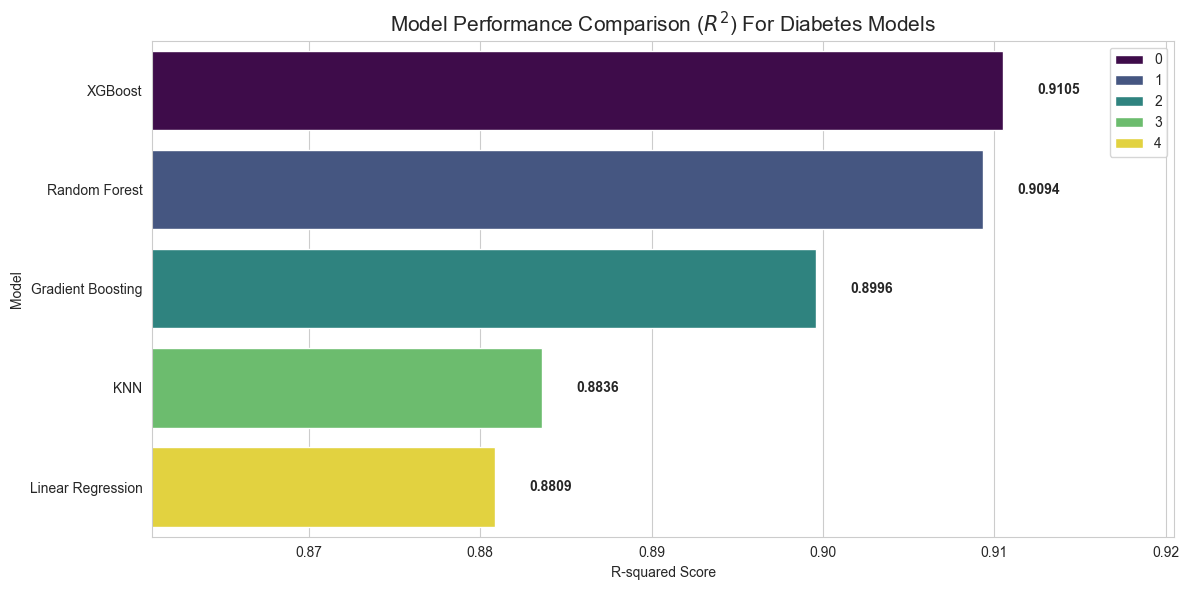

,Model,R2,RMSE
4,XGBoost,0.910509,0.789319
2,Random Forest,0.909361,0.794368
3,Gradient Boosting,0.899579,0.836133
1,KNN,0.883603,0.900191
0,Linear Regression,0.880853,0.910762


In [35]:
# Collect all model predictions for diabetes
diabetes_models = {
    "Linear Regression": diabetes_lr_model.predict(X_test_scaled),
    "KNN": diabetes_knn_grid.predict(X_test_scaled),
    "Random Forest": diabetes_rf_grid.predict(X_test),
    "Gradient Boosting": diabetes_gb_model.predict(X_test),
    "XGBoost": diabetes_xgb_grid.predict(X_test)
}

# Calculate R2 and RMSE for each
diabetes_results = []
for name, preds in diabetes_models.items():
    r2 = r2_score(y_test["diabetes"], preds)
    rmse = np.sqrt(mean_squared_error(y_test["diabetes"], preds))
    diabetes_results.append({"Model": name, "R2": r2, "RMSE": rmse})
diabetes_results_df = pd.DataFrame(diabetes_results).sort_values(by='R2', ascending=False)

# Barplot for R2
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")
sns.barplot(x='R2', y='Model', data=diabetes_results_df, palette='viridis', hue=range(len(diabetes_results_df)))
plt.title("Model Performance Comparison ($R^2$) For Diabetes Models", fontsize=15)
plt.xlabel("R-squared Score")
plt.xlim(min(diabetes_results_df['R2']) - 0.02, max(diabetes_results_df['R2']) + 0.01)
for i, val in enumerate(diabetes_results_df['R2']):
    plt.text(val + 0.002, i, f"{val:.4f}", va='center', fontweight='bold')
plt.tight_layout()
plt.show()

# Display the sorted table
display(diabetes_results_df)

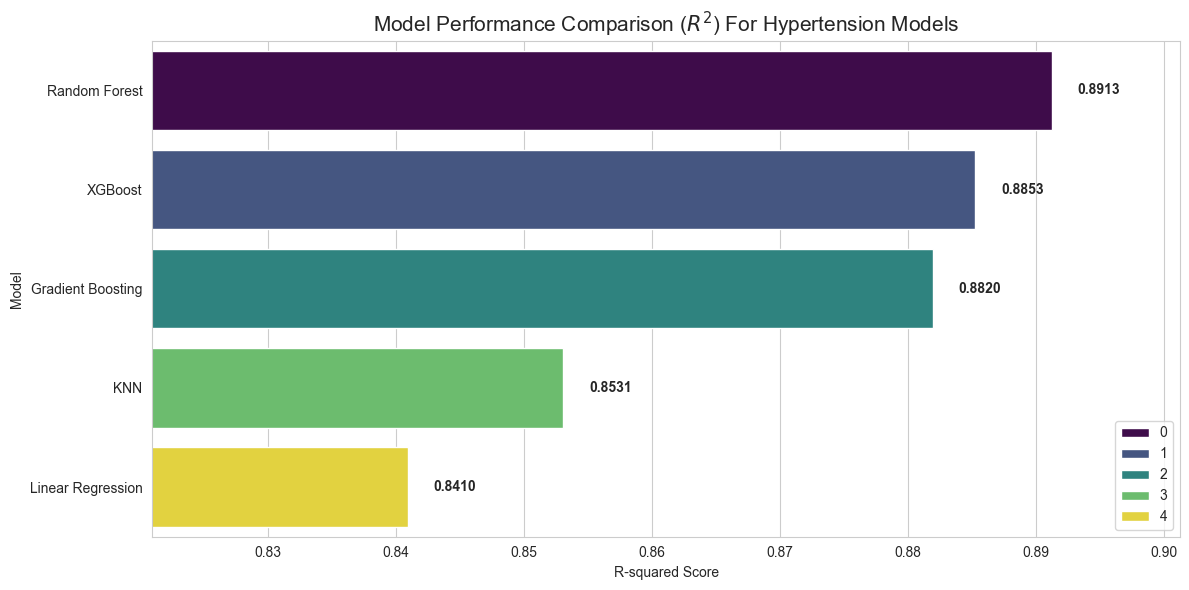

,Model,R2,RMSE
2,Random Forest,0.891284,1.758878
4,XGBoost,0.885292,1.806699
3,Gradient Boosting,0.881990,1.832516
1,KNN,0.853094,2.044598
0,Linear Regression,0.840952,2.127418


In [36]:
# Collect all model predictions for hypertension
hypertension_models = {
    "Linear Regression": hypertension_lr_model.predict(X_test_scaled),
    "KNN": hypertension_knn_grid.predict(X_test_scaled),
    "Random Forest": hypertension_rf_grid.predict(X_test),
    "Gradient Boosting": hypertension_gb_model.predict(X_test),
    "XGBoost": hypertension_xgb_grid.predict(X_test)
}

# Calculate R2 and RMSE for each
hypertension_results = []
for name, preds in hypertension_models.items():
    r2 = r2_score(y_test["hypertension"], preds)
    rmse = np.sqrt(mean_squared_error(y_test["hypertension"], preds))
    hypertension_results.append({"Model": name, "R2": r2, "RMSE": rmse})
hypertension_results_df = pd.DataFrame(hypertension_results).sort_values(by='R2', ascending=False)

# Barplot for R2
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")
sns.barplot(x='R2', y='Model', data=hypertension_results_df, palette='viridis', hue=range(len(hypertension_results_df)))
plt.title("Model Performance Comparison ($R^2$) For Hypertension Models", fontsize=15)
plt.xlabel("R-squared Score")
plt.xlim(min(hypertension_results_df['R2']) - 0.02, max(hypertension_results_df['R2']) + 0.01)
for i, val in enumerate(hypertension_results_df['R2']):
    plt.text(val + 0.002, i, f"{val:.4f}", va='center', fontweight='bold')
plt.tight_layout()
plt.show()

# Display the sorted table
display(hypertension_results_df)


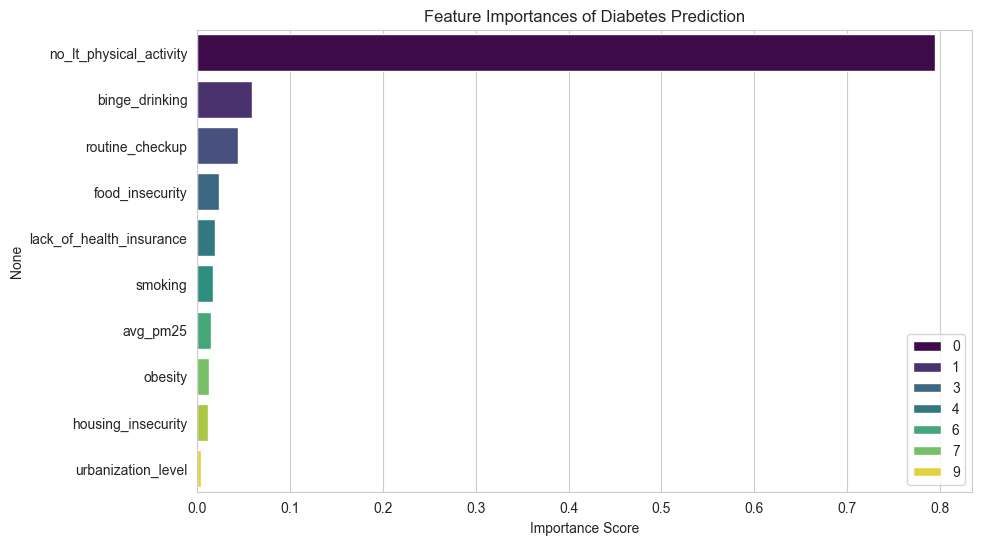

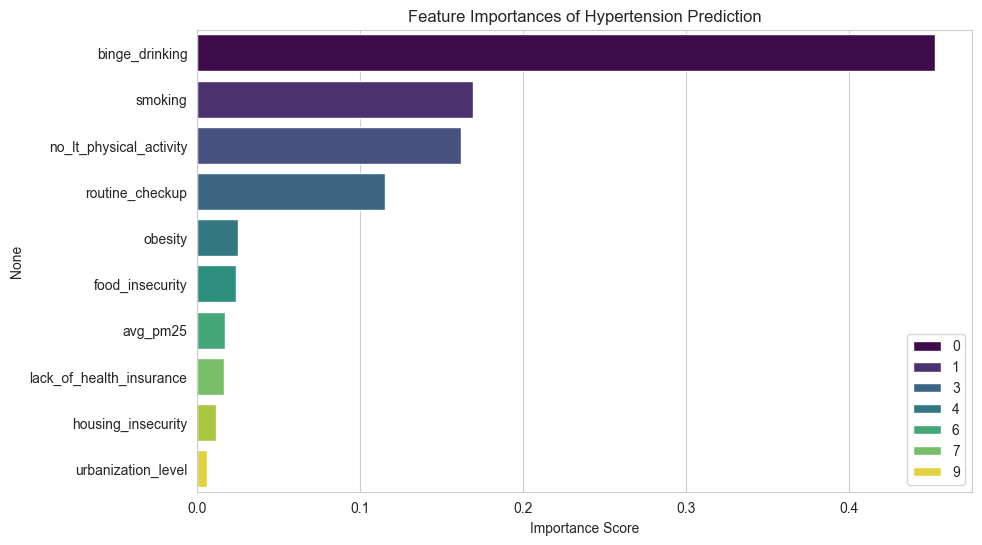

In [37]:
import seaborn as sns

# Extract importance from the Random Forest models
diabetes_importances = diabetes_rf_grid.best_estimator_.feature_importances_
diabetes_feat_importances = pd.Series(diabetes_importances, index=features).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=diabetes_feat_importances.values, y=diabetes_feat_importances.index, palette='viridis', hue=range(len(diabetes_feat_importances)))
plt.title("Feature Importances of Diabetes Prediction")
plt.xlabel("Importance Score")
plt.show()

hypertension_importances = hypertension_rf_grid.best_estimator_.feature_importances_
hypertension_feat_importances = pd.Series(hypertension_importances, index=features).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=hypertension_feat_importances.values, y=hypertension_feat_importances.index, palette='viridis', hue=range(len(hypertension_feat_importances)))
plt.title("Feature Importances of Hypertension Prediction")
plt.xlabel("Importance Score")
plt.show()

**Interpretation of the Results**: The comparative analysis of multiple machine learning architectures provides strong statistical evidence to support Hypothesis 2 ($H_2$). The results demonstrate that advanced ensemble methods consistently outperform traditional linear and neighborhood-based approaches in predicting the prevalence of both diabetes and hypertension across U.S. counties.

- Performance Leaders: XGBoost and Random Forest emerged as the top-performing models for both conditions. For diabetes, XGBoost achieved the highest accuracy ($R^2 = 0.9105$, $RMSE = 0.7893$), followed closely by Random Forest ($R^2 = 0.9094$).
- Hypertension Trends: A similar trend was observed for hypertension, with Random Forest leading ($R^2 = 0.8913$), significantly outperforming the Linear Regression baseline ($R^2 = 0.8410$).
- Non-Linearity: The fact that tree-based ensemble models (XGBoost, Random Forest, and Gradient Boosting) consistently yielded higher $R^2$ values and lower error rates ($RMSE$) than Linear Regression confirms that the relationship between environmental stressors like PM2.5 and public health is governed by complex, non-linear interactions that traditional models fail to fully capture.

Interpreting the Feature Importance of the models allows us to rank the influence of air quality against dominant lifestyle factors:

- Primary Predictors: While behavioral factors like physical inactivity and binge drinking dominate the predictive importance (with inactivity scoring nearly $0.8$ in the diabetes model), PM2.5 maintains a comparable presence in both conditions.
- Environmental Signal: The consistent ranking of `avg_pm25` across multiple high-accuracy models proves that air pollution is one of the essential features for forecasting public health outcomes. It provides unique predictive value that cannot be explained away by socioeconomic or behavioral factors alone.

**Final Verdict on $H_2$** Hypothesis 2 is Supported. Advanced algorithms -specifically XGBoost and Random Forest- provide a more robust and precise landscape of public health risks than traditional linear frameworks. By explaining approximately 91% of the variance in diabetes prevalence and 89% in hypertension, these models establish that a machine learning approach is necessary to accurately account for the geographic and environmental complexities of chronic disease in the United States

## 4. - Testing Urbanization Effect on PM2.5 and Disease Prevalence for $H_3$

The **Secondary Hypothesis (H3)** states:
"The strength of the association between PM2.5 and chronic disease prevalence varies significantly based on urbanization levels, with urban counties showing a stronger association due to higher pollution levels."

We will test this using two strategies:
1. **Seperate Modeling:** Training separate Random Forest models for Urban vs. Rural counties to compare the relative importance of PM2.5 in each environment.
2. **Interaction Feature:** Creating an interaction term between PM2.5 and Urbanization to see if the model identifies this "combined" effect as a significant predictor of disease.

This cell splits the data and compares how the Feature Importance of PM2.5 ranks in cities versus rural areas.

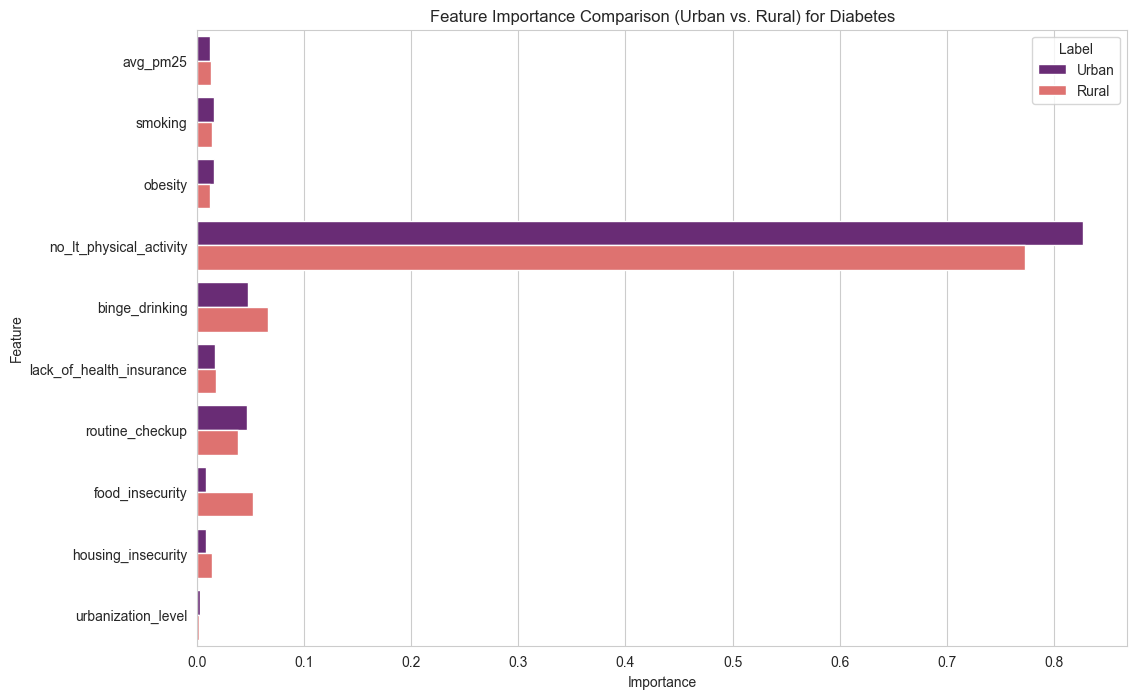

PM2.5 Importance in Urban: 0.0121
PM2.5 Importance in Rural: 0.0127


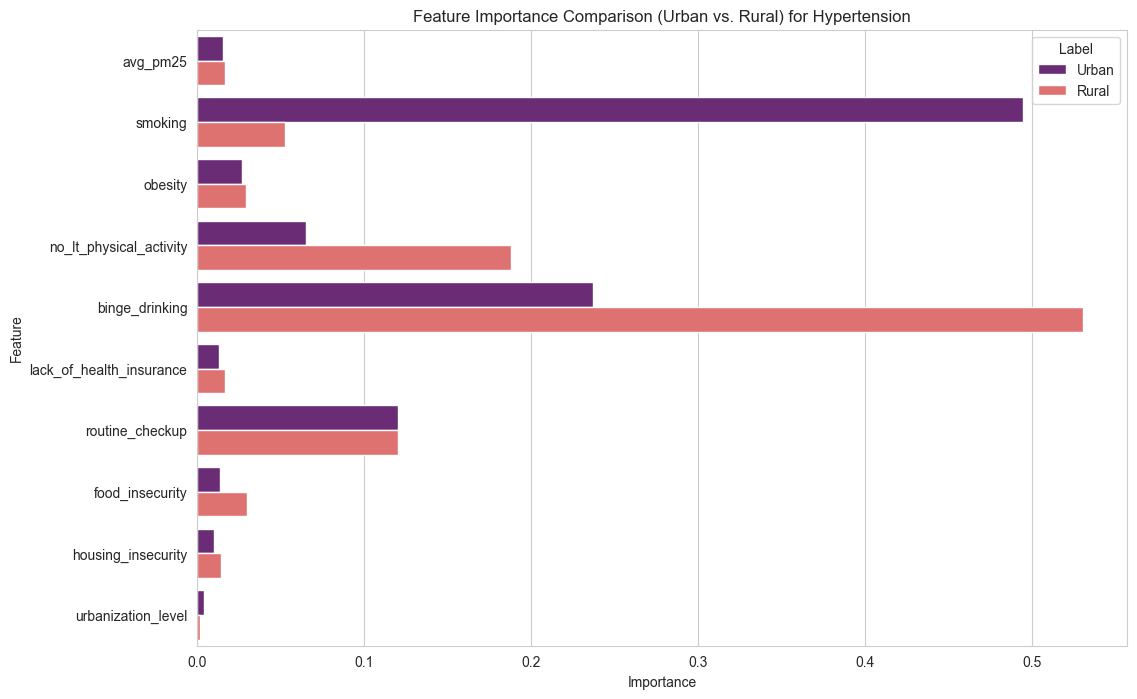

PM2.5 Importance in Urban: 0.0156
PM2.5 Importance in Rural: 0.0168


In [38]:
from sklearn.ensemble import RandomForestRegressor

# Separate Urban (NCHS 1-4) and Rural (NCHS 5-6) subsets
X_urban = X[X["urbanization_level"] <= 4].copy()
X_rural = X[X["urbanization_level"] >= 5].copy()
y_urban = y.loc[X_urban.index]
y_rural = y.loc[X_rural.index]


def get_seperated_importance(subset_X, subset_y, target, label):    
    # Train the Random Forest model from
    model = RandomForestRegressor(n_estimators=200, max_depth=10, random_state=42)
    model.fit(subset_X, subset_y[target])
    
    # Extract Feature Importance
    importance_df = pd.DataFrame({
        'Feature': features,
        'Importance': model.feature_importances_,
        'Type': target,
        'Label': label
    })
    return importance_df

# Run models for both groups
diabetes_urban_imp = get_seperated_importance(X_urban, y_urban, "diabetes",  "Urban")
diabetes_rural_imp = get_seperated_importance(X_rural, y_rural, "diabetes", "Rural")

# Combine and Visualize
diabetes_stratified_df = pd.concat([diabetes_urban_imp, diabetes_rural_imp])
plt.figure(figsize=(12, 8))
sns.barplot(data=diabetes_stratified_df, x='Importance', y='Feature', hue='Label', palette='magma')
plt.title("Feature Importance Comparison (Urban vs. Rural) for Diabetes")
plt.show()

# Print specific rank of PM2.5 for both
for label in ["Urban", "Rural"]:
    val = diabetes_stratified_df[(diabetes_stratified_df['Label'] == label) & (diabetes_stratified_df['Feature'] == 'avg_pm25')]['Importance'].values[0]
    print(f"PM2.5 Importance in {label}: {val:.4f}")

hypertension_urban_imp = get_seperated_importance(X_urban, y_urban, "hypertension",  "Urban")
hypertension_rural_imp = get_seperated_importance(X_rural, y_rural, "hypertension", "Rural")

hypertension_stratified_df = pd.concat([hypertension_urban_imp, hypertension_rural_imp])
plt.figure(figsize=(12, 8))
sns.barplot(data=hypertension_stratified_df, x='Importance', y='Feature', hue='Label', palette='magma')
plt.title("Feature Importance Comparison (Urban vs. Rural) for Hypertension")
plt.show()

for label in ["Urban", "Rural"]:
    val = hypertension_stratified_df[(hypertension_stratified_df['Label'] == label) & (hypertension_stratified_df['Feature'] == 'avg_pm25')]['Importance'].values[0]
    print(f"PM2.5 Importance in {label}: {val:.4f}")

The interaction term checks if the combination of pollution and urbanization is a more powerful predictor than the variables standing alone.

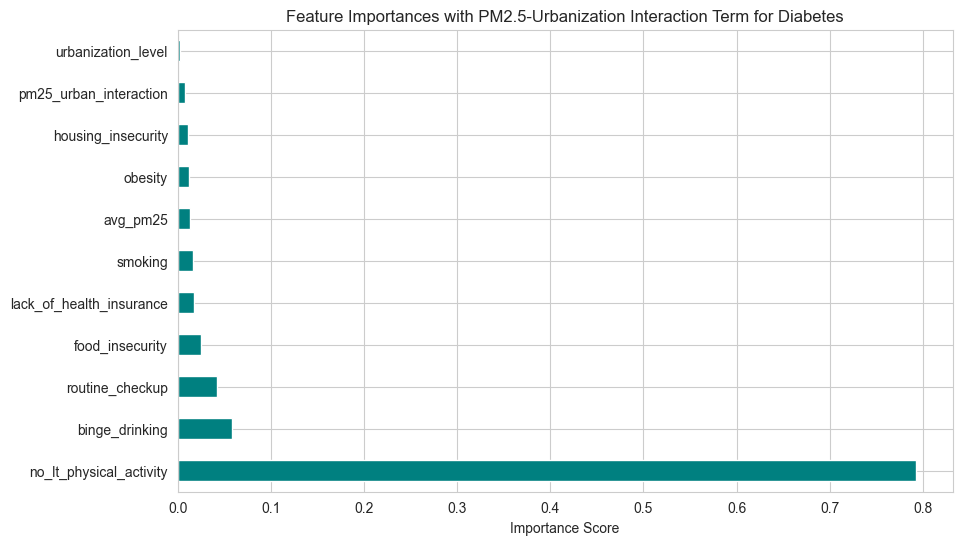

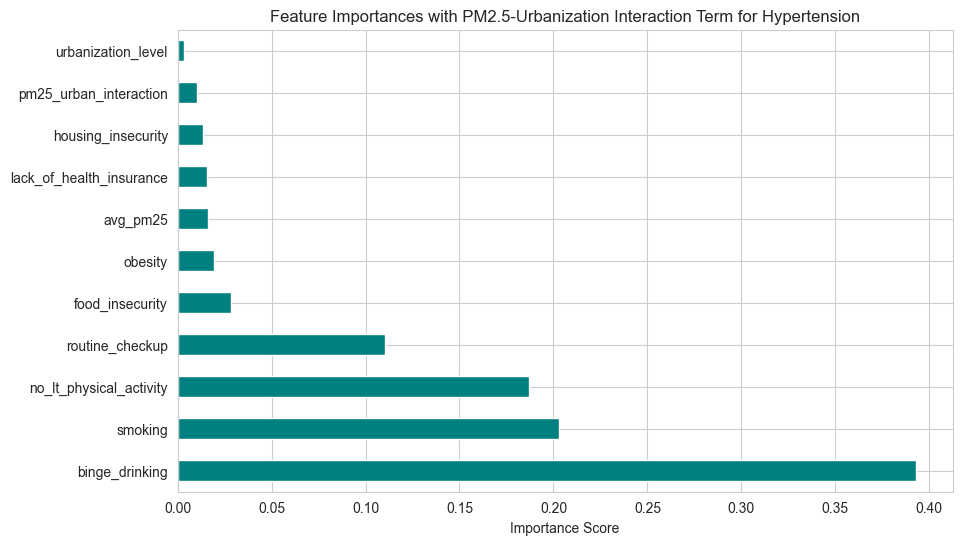

In [39]:
# Create the Interaction Term by multiplying avg_pm25 and urbanization_level
X_int = X.copy()
X_int['pm25_urban_interaction'] = X_int['avg_pm25'] * X_int['urbanization_level']

diabetes_interaction_model = RandomForestRegressor(n_estimators=200, random_state=42)
diabetes_interaction_model.fit(X_int, y['diabetes'])

# Visualize where the Interaction Term ranks for diabetes   
int_importance = pd.Series(diabetes_interaction_model.feature_importances_, index=X_int.columns).sort_values(ascending=False)
plt.figure(figsize=(10, 6))
int_importance.plot(kind='barh', color='teal')
plt.title("Feature Importances with PM2.5-Urbanization Interaction Term for Diabetes")
plt.xlabel("Importance Score")
plt.show()

hypertension_interaction_model = RandomForestRegressor(n_estimators=200, random_state=42)
hypertension_interaction_model.fit(X_int, y['hypertension'])

# Visualize where the Interaction Term ranks for hypertension
int_importance = pd.Series(hypertension_interaction_model.feature_importances_, index=X_int.columns).sort_values(ascending=False)
plt.figure(figsize=(10, 6))
int_importance.plot(kind='barh', color='teal')
plt.title("Feature Importances with PM2.5-Urbanization Interaction Term for Hypertension")
plt.xlabel("Importance Score")
plt.show()

**Interpretation of Tests:** Based on the Machine Learning results derived from both Separate Model Comparison and Interaction Feature Method, we can evaluate the geographic nuances of environmental risk:

The stratified analysis reveals that the predictive weight of air pollution is consistent across different geographic settings. For Diabetes, the importance of `avg_pm25` was 0.0121 in Urban counties compared to 0.0127 in Rural counties. Similarly, for Hypertension, the importance was 0.0156 in Urban areas versus 0.0168 in Rural areas.
- Key Finding: In both disease models, `avg_pm25` showed a slightly higher importance score in Rural counties compared to Urban ones. This indicates that despite higher absolute pollution levels in cities, rural populations may be more sensitive to fluctuations in air quality, potentially due to the compounding effects of an older demographic or limited access to preventative healthcare.

The interaction feature, `pm25_urban_interaction`, was incorporated to test if the combined effect of urbanization and pollution provided unique predictive power.
- Key Finding: In the global models for both Diabetes and Hypertension, the interaction term ranked very low in overall feature importance, appearing at the bottom of the list just above the standalone urbanization level. This suggests that while urbanization and PM2.5 both independently influence health outcomes, they do not have a strong synergistic "multiplier" effect that significantly alters the disease landscape.

**Conclusion for $H_3$**: The hypothesis that urban counties show a stronger association due to higher pollution levels is Rejected. While the predictive models achieved high overall accuracy, the machine learning evidence suggests that:
- Geography is not an intensifier: The strength of PM2.5 as a predictor does not increase in urban environments; in fact, the data shows a marginal increase in importance within rural contexts.
- Independent Risks: Air pollution and urbanization act as independent stressors. The low ranking of the interaction term indicates that the risk posed by PM2.5 is a persistent national issue that goes beyond the urban-rural divide.
These results emphasize that environmental policy must be broad-based, as the health burden of fine particulate matter is just as critical in rural America as it is in major metropolitan centers.

## 5. - Project Conclusion

The modeling phase of this research successfully transitioned from initial data analysis to a predictive framework, providing a reproducible evaluation of environmental health risks.

Through **LASSO regression**, we confirmed **Hypothesis 1 ($H_1$)** by isolating `avg_pm25` as an independent risk factor for diabetes and hypertension after resolving over-adjustment biases found in more complex linear models. 

The "Model Tournament" for **Hypothesis 2 ($H_2$)** demonstrated that advanced ensemble methods like **XGBoost** and **Random Forest** significantly outperform traditional models, explaining over **91% of the variance** in disease prevalence. This suggests that while lifestyle factors remain the primary drivers of public health, the non-linear, compounding effects of long-term air pollution exposure are essential components in accurately forecasting and mitigating the national chronic disease burden.

Finaly, while our separate machine learning analysis led us to reject **Hypothesis 3 ($H_3$)** -finding that PM2.5 importance is actually marginally higher in rural contexts (0.0127 vs 0.0121 for diabetes)- it highlighted the critical need for universal air quality interventions that leave behind the urban-rural divide. 